# Parsing experiments

Here we quickly visualize parsing experiment results.

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import regex as re
from typing import *

In [2]:
def run_stats(output_dir: Path, phase='val'):
    """Returns an iterable of stats for a phase in a given run."""
    iteration_re = re.compile(r'(\w+)-' + phase + '-stats.csv')
    stats_files = output_dir.glob(f'*-{phase}-stats.csv')
    loaded = {}
    for stats_file in stats_files:
        try:
            df = pd.read_csv(stats_file)
            iteration_name = iteration_re.match(stats_file.name).group(1)
            loaded[iteration_name] = df
        except Exception as e:
            print(f'{stats_file}: {e}')
    return loaded

In [3]:
def overall(stats_frame, parser='parse'):
    """Gets the overall results from a stats frame"""
    return stats_frame[stats_frame['exampleId'] == 'all']

In [4]:
def iteration_ordering_key(s):
    if s == 'bootstrap':
        return 0
    return int(s)

def all_stats(stat_frame_dict):
    """Returns a dataframe of overall stats for the iterations in a stat frame dictionary"""
    keys_ordered = sorted(stat_frame_dict.keys(), key=iteration_ordering_key)
    return pd.concat((overall(stat_frame_dict[k]) for k in keys_ordered), ignore_index=True)


In [5]:
iteration_runtime_re = re.compile(r'([\w\-]+) took (\d+) seconds')

def iteration_runtimes(log_path: Path) -> Dict[str, int]:
    result = {}
    with log_path.open() as f:
        for line in f:
            match = iteration_runtime_re.search(line)
            if match:
                k = match.group(1)
                v = int(match.group(2))
                result[k] = v
    return result

In [6]:
def add_runtimes(run, all_frame):
    """Adds runtimes to a frame of iteration-wise stats"""
    runtimes = [v/3600.0 for k, v in iteration_runtimes(run / 'log.txt').items() if 'train' in k]
    # extend / shrink runtimes to length of data frame
    runtimes_extended = (runtimes + ([0] * (len(all_frame) - len(runtimes))))[:len(all_frame)]
    runtimes_acc = [sum(runtimes_extended[:i+1]) for i in range(len(runtimes_extended))]
    all_frame['train_time'] = runtimes_extended
    all_frame['train_time_acc'] = runtimes_acc
    return all_frame

In [7]:
def plot_f1(base_path: Path, subdir=None):
    """
    @param subdir if given, a subdirectory within each run containing the actual stats
    """
    runs = list(sorted(base_path.glob('*')))
    plotted_runs = []  # We add those runs we plot to account for skipped runs
    fig, ax = plt.subplots()
    for run in runs:
        try:
            stats_dir = run / subdir if subdir else run
            stats_frames = run_stats(stats_dir)
            stats = all_stats(stats_frames)
            add_runtimes(stats_dir, stats)
            stats.plot(y='f1', x='train_time_acc', ax=ax)
            plotted_runs.append(run)
        except Exception as e:
            print(f'{run}: {e}')
    plt.legend([run.name for run in plotted_runs])
    return ax

In [8]:
def single_iteration_scores(run: Path):
    try:
        stats_frames = run_stats(run)
        stats = all_stats(stats_frames)
        add_runtimes(run, stats)
        return stats
    except Exception as e:
        print(f'{run}: {e}')

In [9]:
def group_iteration_scores(base_path: Path, subdir=None, sort_numeric=False):
    """
    @param subdir if given, a subdirectory within each run containing the actual stats
    """
    runs = list(base_path.glob('*'))
    if sort_numeric:
        runs = list(sorted(runs, key=lambda p: int(str(p.name))))
    else:
        runs = list(sorted(runs, key=str))
    dfs = {}
    for run in runs:
        try:
            stats_dir = run / subdir if subdir else run
            condition = str(run).split('/')[-1]
            stats = single_iteration_scores(stats_dir)
            dfs[condition] = stats
        except Exception as e:
            print(f'{run}: {e}')
    return dfs

In [10]:
def best_val_scores(run_dict):
    """
    Collects the best validation score in any iteration for each run in the base_path.

    @param run_dict a dictionary of stats dataframes per run
    """
    entries = []
    for condition, stats in run_dict.items():
        try:
            best_row = stats.iloc[stats['f1'].argmax()]
            final_row = stats.iloc[-1]
            entries.append({'condition': condition, 'final_val': final_row['f1'], 'final_train_time': final_row['train_time_acc'], 'best_val': best_row['f1'], 'best_train_time': best_row['train_time_acc']})
        except Exception as e:
            print(f'{condition}: {e}')
    df = pd.DataFrame(entries)
    df.set_index('condition', inplace=True)
    return df

In [11]:
def sort_numeric_index(acc_df):
    return acc_df.set_index(acc_df.index.astype('int64')).sort_index()

In [12]:
def tbl_final_val(stats_dict, column_prefix='final', condition_str='Condition', training_time=True):
    str = ''
    str += r'''\documentclass{standalone}
\usepackage{booktabs}

\begin{document}
\begin{tabular}{lrrr}
  \toprule
  \textbf{''' + condition_str + r'''} &\textbf{Prec} &\textbf{Rec} &\textbf{F1}'''
    if training_time:
        str += r' &\textbf{Training Time (h:m)}'
    str += r'''\\
  \midrule
'''
    for condition, df in stats_dict.items():
        try:
            fmt_condition = r'\textbf{' + condition + '}'
            line = df.iloc[-1]
            f1 = line['f1']
            prec = line['precision']
            rec = line['recall']
            str += f'    {fmt_condition} &{prec:.4} &{rec:.4} &{f1:.4}'
            if training_time:
                train_time = df.at[condition, column_prefix + '_train_time']
                hours = int(train_time)
                minutes = int((train_time - hours) * 60.0)
                str += f' &{hours}:{minutes:02d}'
        except KeyError as e:
            print(e)
            str += f' {fmt_condition} &N/A'
        str += '\\\\\n'
    str += r'''  \bottomrule
\end{tabular}
\end{document}'''
    return str

In [13]:
def tbl_best_val(df, column_prefix='best', condition_str='Condition', training_time=True):
    latex = ''
    latex += r'''\documentclass{standalone}
\usepackage{booktabs}

\begin{document}
\begin{tabular}{lrrr}
  \toprule
  \textbf{''' + condition_str + r'''} &\textbf{Smatch F1}'''
    if training_time:
        latex += r' &\textbf{Training Time (h:m)}'
    latex += r'''\\
  \midrule
'''
    for condition in df.index:
        try:
            fmt_condition = r'\textbf{' + str(condition) + '}'
            smatch = df.at[condition, column_prefix + '_val']
            latex += f'    {fmt_condition} &{smatch:.4}'
            if training_time:
                train_time = df.at[condition, column_prefix + '_train_time']
                hours = int(train_time)
                minutes = int((train_time - hours) * 60.0)
                latex += f' &{hours}:{minutes:02d}'
        except KeyError:
            latex += f' {fmt_condition} &N/A'
        latex += '\\\\\n'
    latex += r'''  \bottomrule
\end{tabular}
\end{document}'''
    return latex

## Sentence length

In [14]:
stats_frame = all_stats(run_stats(Path('../parsing/sentence-length/output/25')))

<AxesSubplot:xlabel='train_time_acc'>

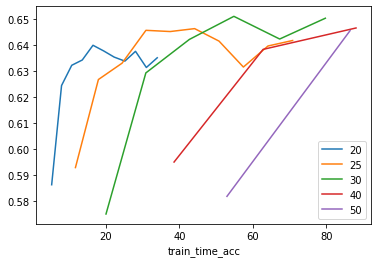

In [15]:
plot_f1(Path('../parsing/sentence-length/output'))

**Conclusion:** There is a moderate performance gain between 25 and 30, but also a large difference in training time, maybe about 50% more. For any larger sentence lengths, the gain is unclear due to long iteration times.

For quick results, 25 seems preferable. 30 might be worth it for cross-checking.

## beam size

<AxesSubplot:xlabel='train_time_acc'>

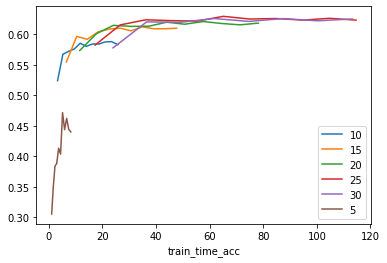

In [16]:
plot_f1(Path('../parsing/beam/output'))

In [17]:
beam_size_run_dict = group_iteration_scores(Path('../parsing/beam/output'))
beam_size_best = sort_numeric_index(best_val_scores(beam_size_run_dict))
beam_size_best

final_val  final_train_time  best_val  best_train_time
condition                                                        
5           0.439929          8.217222  0.471642         5.116389
10          0.583202         25.783889  0.588176        23.381667
15          0.610227         47.700556  0.612406        34.876389
20          0.618602         78.198333  0.621207        57.556389
25          0.623477        114.623056  0.629708        65.067778
30          0.625371        113.271944  0.626086        61.761389

In [18]:
with open('beam-size-results.tex', 'w') as f:
    f.write(tbl_best_val(beam_size_best, column_prefix='final', condition_str='Beam Size'))

<AxesSubplot:xlabel='Beam Size', ylabel='Smatch F1'>

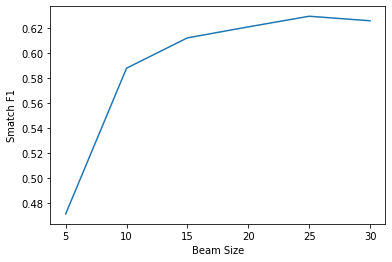

In [19]:
beam_size_best['best_val'].plot(xlabel='Beam Size', ylabel='Smatch F1', legend=False)

**Conclusion:** Beam size 25 is strongest. We don’t seem to need all 10 iterations, so there is some space and beam 25 with sentence length 30 should be possible.

## Training Data

<AxesSubplot:xlabel='train_time_acc'>

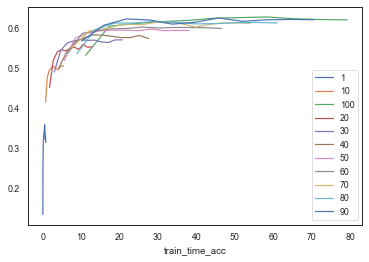

In [23]:
plot_f1(Path('../parsing/training-data/output'), 'parser')

In [24]:
training_data_run_dict = group_iteration_scores(Path('../parsing/training-data/output'), 'parser', sort_numeric=True)
training_data_acc = sort_numeric_index(best_val_scores(training_data_run_dict))

In [25]:
with open('training-data-results.tex', 'w') as f:
    f.write(tbl_final_val(training_data_run_dict, condition_str='Training Data \%', training_time=False))

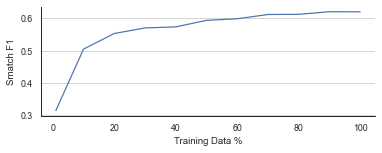

In [26]:
# Print-quality plot score vs training data
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme('paper')
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6, 2))

sns.despine()
sns.lineplot(x=training_data_acc.index.values, y=training_data_acc['final_val'].values)
ax.set_xlabel('Training Data %')
ax.set_ylabel('Smatch F1')
ax.grid(axis='y')

import tikzplotlib
tikzplotlib.save("training-data-f1.tex", axis_width='12cm', axis_height='4cm', extra_axis_parameters=['xmajorticks=true', 'ymajorticks=true'])

plt.show()

## grammar

<AxesSubplot:xlabel='train_time_acc'>

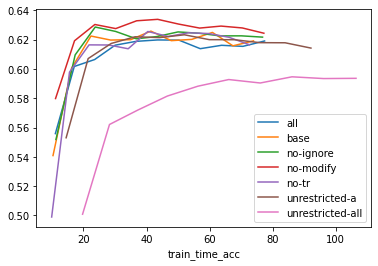

In [ ]:
plot_f1(Path('../parsing/grammar/output'), 'parser')

In [ ]:
grammars_run_dict = group_iteration_scores(Path('../parsing/grammar/output'), 'parser')
grammars_best_val_scores = best_val_scores(grammars_run_dict)

In [ ]:
grammars_best_val_scores

final_val  final_train_time  best_val  best_train_time
condition                                                               
all                0.619081         77.446389  0.619787        43.513056
base               0.619144         73.930278  0.625811        41.374167
no-ignore          0.621704         76.797500  0.628590        23.728889
no-modify          0.624374         77.221389  0.633854        43.536667
no-tr              0.616463         72.655556  0.625557        40.413889
unrestricted-a     0.614227         92.151111  0.623307        51.990556
unrestricted-all   0.593580        106.452500  0.594616        86.144444

In [ ]:
with open('grammar-results.tex', 'w') as f:
    f.write(tbl_final_val(grammars_run_dict, condition_str='Grammar', training_time=False))

## bootstrap

<AxesSubplot:xlabel='train_time_acc'>

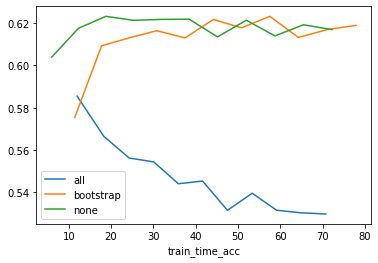

In [ ]:
plot_f1(Path('../parsing/bootstrap/output'))

In [ ]:
bootstrap_run_dict = group_iteration_scores(Path('../parsing/bootstrap/output'))
bootstrap_results = best_val_scores(bootstrap_run_dict)
bootstrap_results

final_val  final_train_time  best_val  best_train_time
condition                                                        
all         0.529838         70.716111  0.585487        11.999722
bootstrap   0.618935         77.890556  0.623216        57.529167
none        0.616964         72.184444  0.623217        18.788889

In [ ]:
with open('bootstrap-results.tex', 'w') as f:
    f.write(tbl_best_val(bootstrap_results, column_prefix='final', condition_str='Bootstrapping', training_time=False))

## features

<AxesSubplot:xlabel='train_time_acc'>

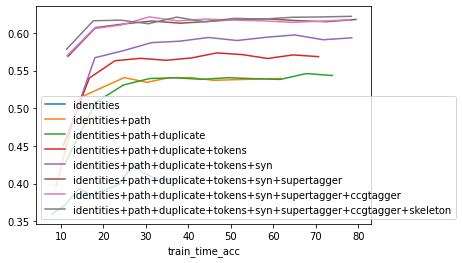

In [ ]:
plot_f1(Path('../parsing/features/output'))

In [ ]:
features_run_dict = group_iteration_scores(Path('../parsing/features/output'))
features_best_val_scores = best_val_scores(features_run_dict)
features_best_val_scores

final_val  \
condition                                                       
identities                                           0.400178   
identities+path                                      0.539456   
identities+path+duplicate                            0.543406   
identities+path+duplicate+tokens                     0.568403   
identities+path+duplicate+tokens+syn                 0.593447   
identities+path+duplicate+tokens+syn+supertagger     0.617726   
identities+path+duplicate+tokens+syn+supertagge...   0.617424   
identities+path+duplicate+tokens+syn+supertagge...   0.621924   

                                                    final_train_time  \
condition                                                              
identities                                                 39.647222   
identities+path                                            61.812222   
identities+path+duplicate                                  73.882500   
identities+path+duplicate+tokens                           70.641944   
identities+path+duplicate+tokens+syn                       78.433611   
identities+path+duplicate+tokens+syn+supertagger           79.439722   
identities+path+duplicate+tokens+syn+supertagge...         77.845556   
identities+path+duplicate+tokens+syn+supertagge...         78.338611   

                                                    best_val  best_train_time  
condition                                                                      
identities                                          0.423346        26.846389  
identities+path                                     0.540615        24.906111  
identities+path+duplicate                           0.545959        67.753611  
identities+path+duplicate+tokens                    0.573366        46.687778  
identities+path+duplicate+tokens+syn                0.597239        65.018611  
identities+path+duplicate+tokens+syn+supertagger    0.618515        58.571389  
identities+path+duplicate+tokens+syn+supertagge...  0.621243        30.774722  
identities+path+duplicate+tokens+syn+supertagge...  0.621924        78.338611

<AxesSubplot:xlabel='features', ylabel='Smatch F1'>

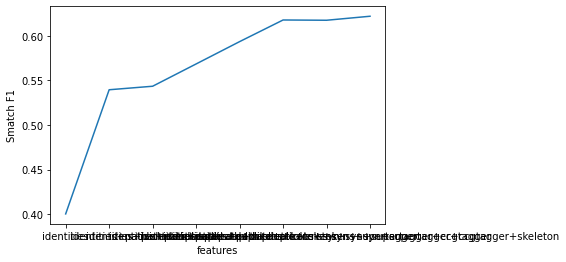

In [ ]:
features_best_val_scores['final_val'].plot(xlabel='features', ylabel='Smatch F1', legend=False)

In [ ]:
def tbl_features(df):
    str = ''
    str += r'''\documentclass{standalone}
\usepackage{booktabs}

\begin{document}
\begin{tabular}{lrrr}
  \toprule
  \textbf{Feature Set} &\textbf{Smatch F1}\\
  \midrule
'''
    last_condition = ''
    for condition in df.index:
        try:
            display_condition = condition.removeprefix(last_condition)
            last_condition = condition
            fmt_condition = r'\textbf{' + display_condition + '}'
            smatch = df.at[condition, 'final_val']
            str += f'  {fmt_condition} &{smatch:.4}'
        except KeyError:
            str += f' {fmt_condition} &N/A'
        str += '\\\\\n'
    str += r'''  \bottomrule
\end{tabular}
\end{document}'''
    return str

In [ ]:
with open('features-results.tex', 'w') as f:
    f.write(tbl_features(features_best_val_scores))

## baseline

In [14]:
baseline_run_dict = group_iteration_scores(Path('../parsing/baseline/output'))
baseline_results = best_val_scores(baseline_run_dict)
baseline_results

final_val  final_train_time  best_val  best_train_time
condition                                                        
1           0.617894         88.032500  0.624597        38.933056
2           0.625378         77.801389  0.628939        50.731944
3           0.619611         77.905278  0.621903        57.632222

In [15]:
baseline_stats = group_iteration_scores(Path('../parsing/baseline/output'))
baseline_stats = {k: df.iloc[:11] for k, df in baseline_stats.items()}

In [16]:
baseline_stats['1']

iterationId parserId exampleId  total  correct  incorrect  precision  \
0   bootstrap-val    parse       all  26602    13881       7040   0.663496   
1           1-val    parse       all  26602    14645       6616   0.688820   
2           2-val    parse       all  26602    14298       6151   0.699203   
3           3-val    parse       all  26602    14577       6373   0.695800   
4           4-val    parse       all  26602    14921       6255   0.704618   
5           5-val    parse       all  26602    14951       6443   0.698841   
6           6-val    parse       all  26602    14687       6347   0.698250   
7           7-val    parse       all  26602    14895       6332   0.701701   
8           8-val    parse       all  26602    14743       6384   0.697827   
9           9-val    parse       all  26602    14780       6331   0.700109   
10         10-val    parse       all  26602    14737       6583   0.691229   

      recall        f1  train_time  train_time_acc  
0   0.521803  0.584180   12.165833       12.165833  
1   0.550523  0.611955    6.403611       18.569444  
2   0.537478  0.607766    6.641389       25.210833  
3   0.547966  0.613097    6.747222       31.958056  
4   0.560898  0.624597    6.975000       38.933056  
5   0.562025  0.623010    6.909722       45.842778  
6   0.552101  0.616634    6.977500       52.820278  
7   0.559920  0.622844    7.026944       59.847222  
8   0.554206  0.617780    7.017500       66.864722  
9   0.555597  0.619538    7.041111       73.905833  
10  0.553981  0.615041    7.047500       80.953333

In [17]:
with open('baseline-results.tex', 'w') as f:
    f.write(tbl_final_val(baseline_stats, column_prefix='final', condition_str='Run', training_time=False))

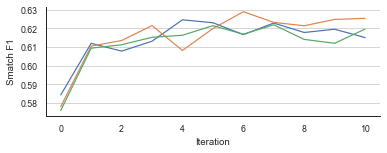

In [22]:
# Print-quality plot of convergence
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme('paper')
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6, 2))
ax.set_xlabel('Iteration')
ax.set_ylabel('Smatch F1')

sns.despine()
for df in baseline_stats.values():
    sns.lineplot(x=df.index.values, y=df['f1'].values)
ax.grid(axis='y')

import tikzplotlib

tikzplotlib.save("baseline-training.tex", axis_width='12cm', axis_height='4cm', extra_axis_parameters=['xmajorticks=true', 'ymajorticks=true'])

plt.show()


## full

In [ ]:
full_run_dict = {'parse': single_iteration_scores(Path('../parsing/full/output'))}
full_scores = best_val_scores(full_run_dict)
full_scores

final_val  final_train_time  best_val  best_train_time
condition                                                        
parse       0.630078        134.318889  0.630078       134.318889

## full-no-modify

In [ ]:
full_no_modify_run_dict = group_iteration_scores(Path('../parsing/full-no-modify/output/parser'))
full_no_modify_scores = best_val_scores(full_no_modify_run_dict)
full_no_modify_scores

final_val  final_train_time  best_val  best_train_time
condition                                                        
1           0.629456        130.668611  0.633061        95.690278
2           0.634575        113.504444  0.637441        96.215833
3           0.630159        128.460833  0.632004       111.303333